#Load and Label All Data

In [ ]:
import os
import pandas as pd
import numpy as np

def load_folder_data(folder_path, label):
    data = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, sep='\t', header=None)
            df = df.iloc[:, 1:]
            if df.shape == (300, 8):
                data.append((df.values, label))
    return data

# Path to the folders
hq_path = '/content/drive/MyDrive/dataset/HQ_Coffee'
aq_path = '/content/drive/MyDrive/dataset/AQ_Coffee'
lq_path = '/content/drive/MyDrive/dataset/LQ_Coffee'

# Load all files with class labels
hq_data = load_folder_data(hq_path, label=2)
aq_data = load_folder_data(aq_path, label=1)
lq_data = load_folder_data(lq_path, label=0)

all_data = hq_data + aq_data + lq_data


In [ ]:
len(all_data)

58

In [ ]:
print(len(hq_data[0]))
print(hq_data[0])
print(len(aq_data))
print(len(lq_data))

2
(array([[38.115066, 78.279021, 24.974374, ..., 51.932296, 49.571883,
        42.770025],
       [37.430021, 77.172739, 24.596942, ..., 51.586297, 49.412471,
        42.406002],
       [37.917076, 77.172739, 24.643595, ..., 50.739517, 49.412471,
        42.892619],
       ...,
       [35.588262, 60.625254, 21.036988, ..., 37.42962 , 34.293739,
        23.340313],
       [35.500392, 61.804319, 20.858501, ..., 37.720601, 33.885384,
        23.297712],
       [35.588262, 60.625254, 21.001092, ..., 37.526169, 34.376449,
        23.383043]]), 2)
10
28


#Normalize All Sensor Data

In [ ]:
from sklearn.preprocessing import StandardScaler

X_all = [sample[0] for sample in all_data]
X_stacked = np.vstack(X_all)  # Shape: (N × 300, 8)

scaler = StandardScaler()
scaler.fit(X_stacked)

# Apply normalization
normalized_data = [(scaler.transform(x), label) for x, label in all_data]


#Prepare Tensors and DataLoader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.stack([torch.tensor(x, dtype=torch.float32) for x, _ in normalized_data])  # (num_samples, 300, 8)
y_tensor = torch.tensor([label for _, label in normalized_data])  # (num_samples,)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=True)



#Define Transformer Model

In [ ]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=8, d_model=64, nhead=4, num_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True  # ✅ This is key to fix the warning and permute issue
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, x):  # x: (B, 300, 8)
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output_proj(x)


#Train the Transformer

In [ ]:
model = TimeSeriesTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # 🔽 lower LR
criterion = nn.MSELoss()

for epoch in range(100):
    total_loss = 0
    model.train()

    for x_batch, _ in loader:  # x_batch: (B, 300, 8)
        output = model(x_batch)
        loss = criterion(output, x_batch)

        if torch.isnan(loss):
            print("⚠️ Skipping NaN loss")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 1 | Loss: 7.0887
Epoch 2 | Loss: 2.8027
Epoch 3 | Loss: 1.7362
Epoch 4 | Loss: 1.3268
Epoch 5 | Loss: 1.0560
Epoch 6 | Loss: 0.8970
Epoch 7 | Loss: 0.7873
Epoch 8 | Loss: 0.6408
Epoch 9 | Loss: 0.5981
Epoch 10 | Loss: 0.5722
Epoch 11 | Loss: 0.5102
Epoch 12 | Loss: 0.4754
Epoch 13 | Loss: 0.4735
Epoch 14 | Loss: 0.4702
Epoch 15 | Loss: 0.4120
Epoch 16 | Loss: 0.4287
Epoch 17 | Loss: 0.4298
Epoch 18 | Loss: 0.3744
Epoch 19 | Loss: 0.3753
Epoch 20 | Loss: 0.3529
Epoch 21 | Loss: 0.3356
Epoch 22 | Loss: 0.3206
Epoch 23 | Loss: 0.3223
Epoch 24 | Loss: 0.3033
Epoch 25 | Loss: 0.2786
Epoch 26 | Loss: 0.3040
Epoch 27 | Loss: 0.2792
Epoch 28 | Loss: 0.2674
Epoch 29 | Loss: 0.2440
Epoch 30 | Loss: 0.2370
Epoch 31 | Loss: 0.2701
Epoch 32 | Loss: 0.2237
Epoch 33 | Loss: 0.2227
Epoch 34 | Loss: 0.2171
Epoch 35 | Loss: 0.2155
Epoch 36 | Loss: 0.2120
Epoch 37 | Loss: 0.2078
Epoch 38 | Loss: 0.1906
Epoch 39 | Loss: 0.2241
Epoch 40 | Loss: 0.1922
Epoch 41 | Loss: 0.1802
Epoch 42 | Loss: 0.1760
E

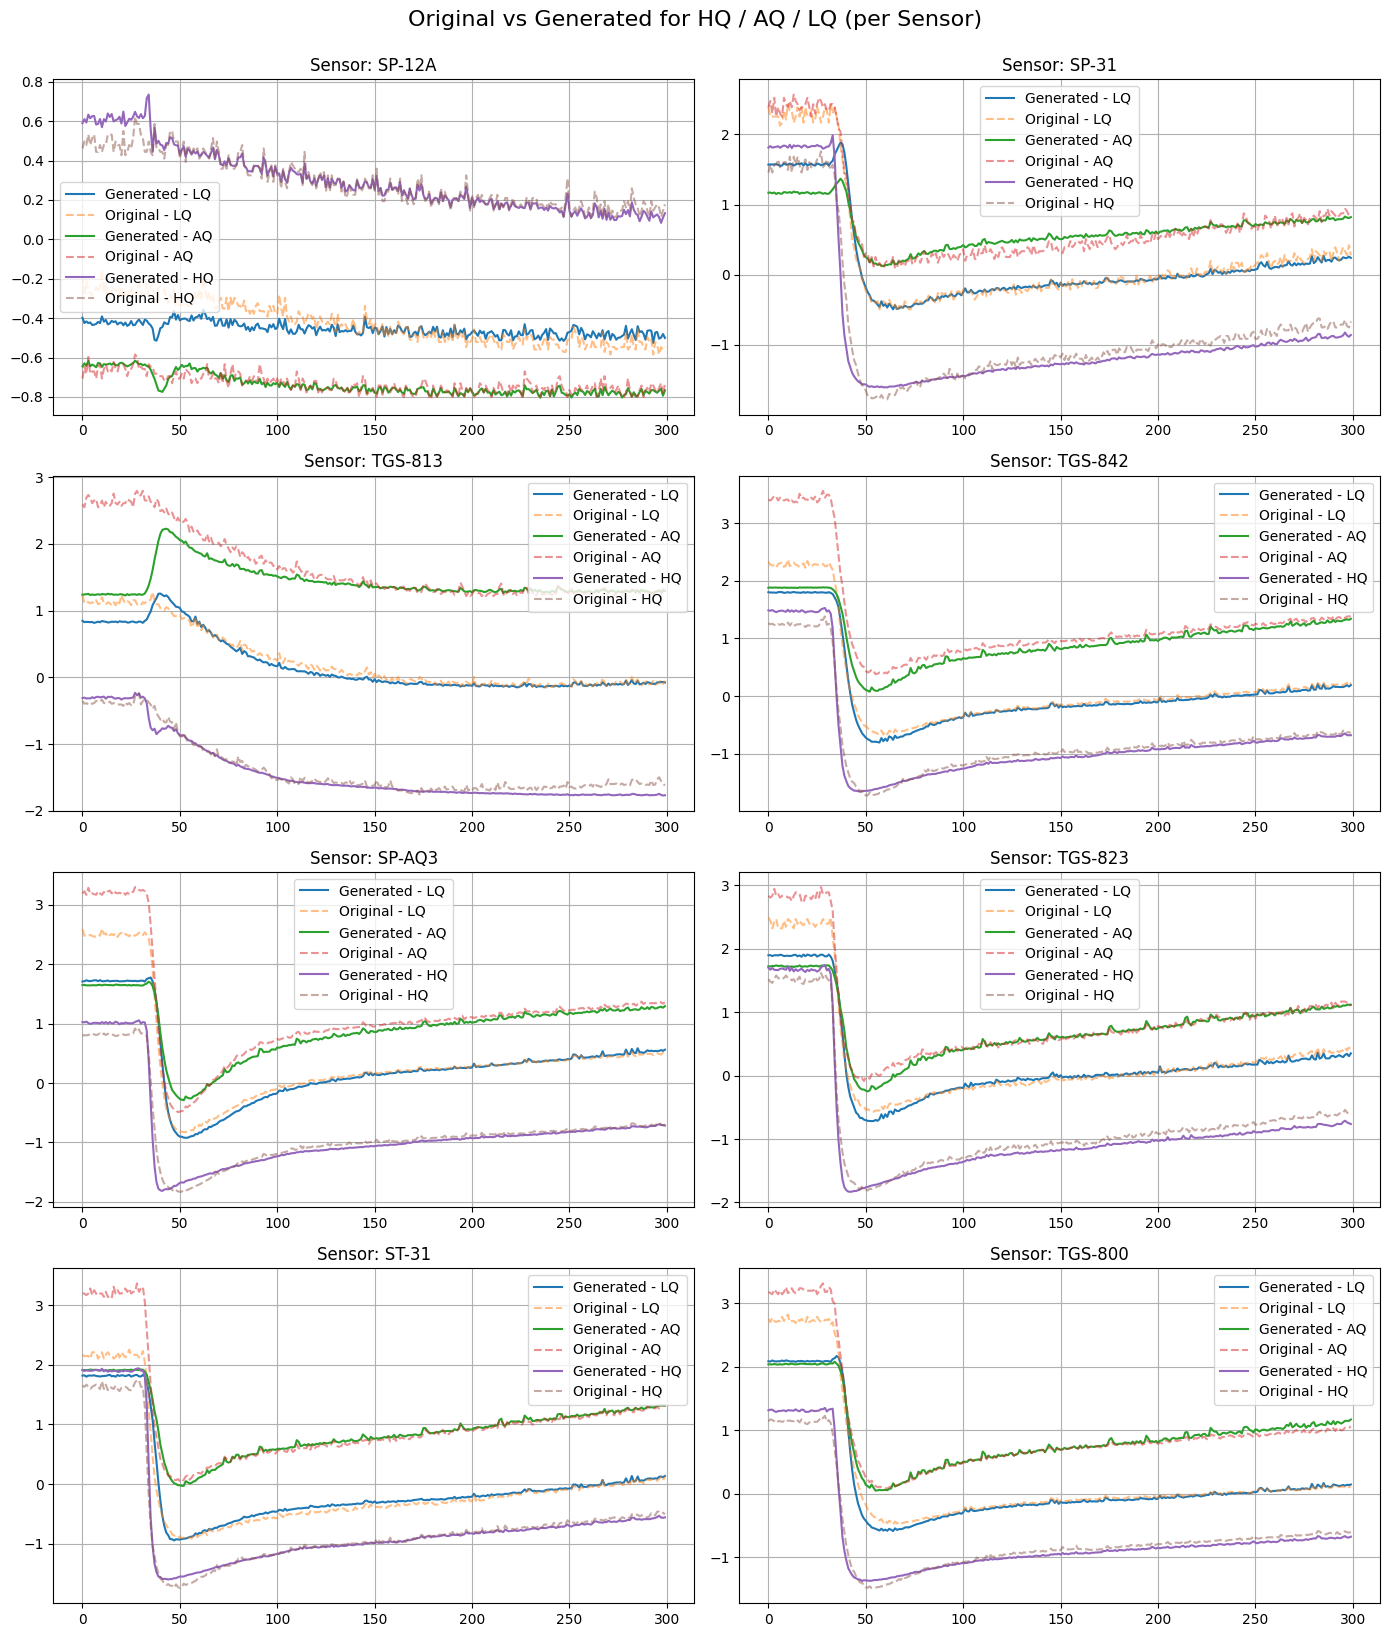

In [ ]:
import matplotlib.pyplot as plt

SENSOR_COLUMNS = ["SP-12A", "SP-31", "TGS-813", "TGS-842", "SP-AQ3", "TGS-823", "ST-31", "TGS-800"]

# Sample one example from each class (0 = HQ, 1 = AQ, 2 = LQ)
examples = {}
for idx, (x, label) in enumerate(normalized_data):
    if label not in examples:
        examples[label] = (idx, x)
    if len(examples) == 3:
        break

# Set up plots: one row per sensor, 3 curves per plot
fig, axs = plt.subplots(4, 2, figsize=(14, 16))  # 4 rows × 2 columns = 8 sensors
axs = axs.flatten()

for i, sensor in enumerate(SENSOR_COLUMNS):
    ax = axs[i]

    for label, (idx, x_norm) in examples.items():
        model.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0)  # (1, 300, 8)
            generated = model(x_tensor).squeeze(0).numpy()

        ax.plot(generated[:, i], label=f'Generated - {"HQ" if label==0 else "AQ" if label==1 else "LQ"}')
        ax.plot(x_norm[:, i], '--', alpha=0.5, label=f'Original - {"HQ" if label==0 else "AQ" if label==1 else "LQ"}')

    ax.set_title(f"Sensor: {sensor}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Original vs Generated for HQ / AQ / LQ (per Sensor)", fontsize=16, y=1.02)
plt.show()


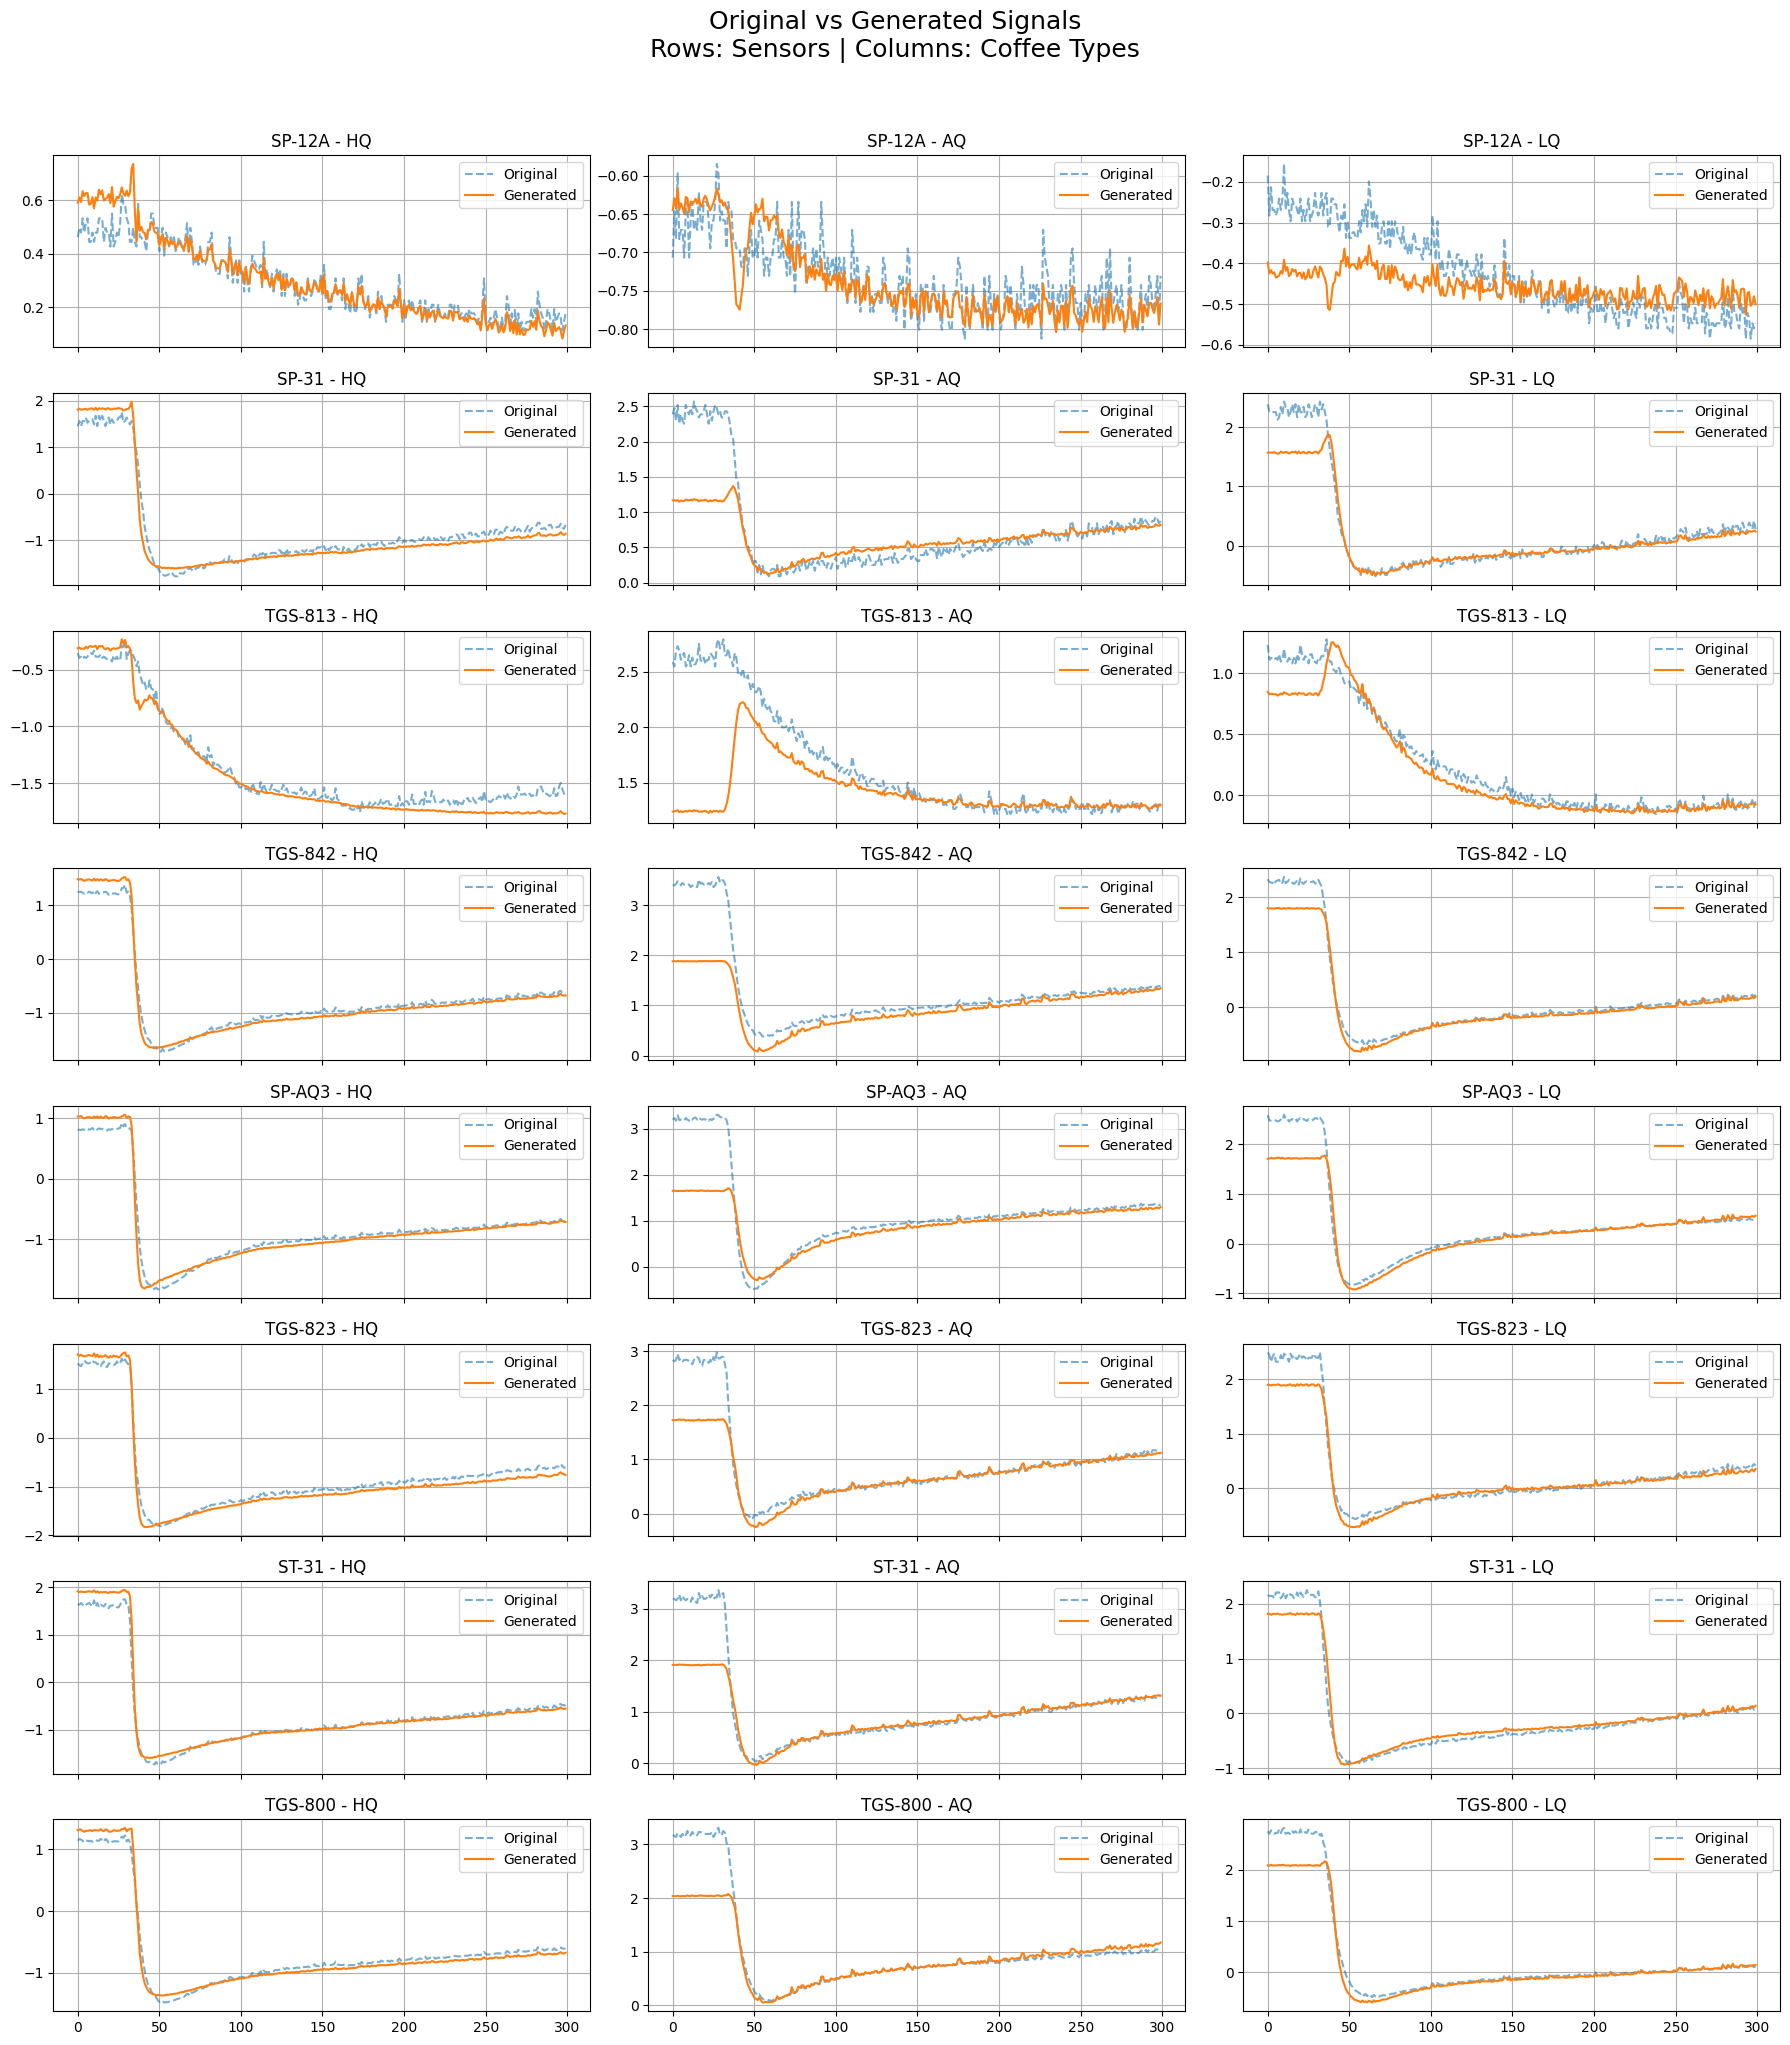

In [ ]:
import matplotlib.pyplot as plt
import torch

SENSOR_COLUMNS = ["SP-12A", "SP-31", "TGS-813", "TGS-842", "SP-AQ3", "TGS-823", "ST-31", "TGS-800"]
COFFEE_LABELS = {0: "HQ", 1: "AQ", 2: "LQ"}

# Sample one example per coffee type
examples = {}
for idx, (x, label) in enumerate(normalized_data):
    if label not in examples:
        examples[label] = (idx, x)
    if len(examples) == 3:
        break

fig, axs = plt.subplots(8, 3, figsize=(18, 20), sharex=True)
plt.subplots_adjust(hspace=0.5)

for sensor_idx, sensor_name in enumerate(SENSOR_COLUMNS):
    for class_idx, label in enumerate([0, 1, 2]):  # HQ, AQ, LQ
        idx, x_norm = examples[label]
        x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0)  # (1, 300, 8)

        model.eval()
        with torch.no_grad():
            recon = model(x_tensor)
            recon = recon.squeeze(0).numpy()  # (300, 8)

        ax = axs[sensor_idx, class_idx]
        ax.plot(x_norm[:, sensor_idx], '--', alpha=0.6, label="Original")
        ax.plot(recon[:, sensor_idx], label="Generated")
        ax.set_title(f"{sensor_name} - {COFFEE_LABELS[label]}")
        ax.legend()
        ax.grid(True)

plt.suptitle("Original vs Generated Signals\nRows: Sensors | Columns: Coffee Types", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


#Generate Synthetic Sample

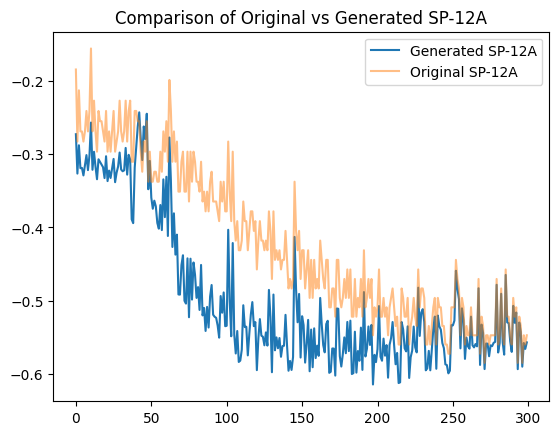

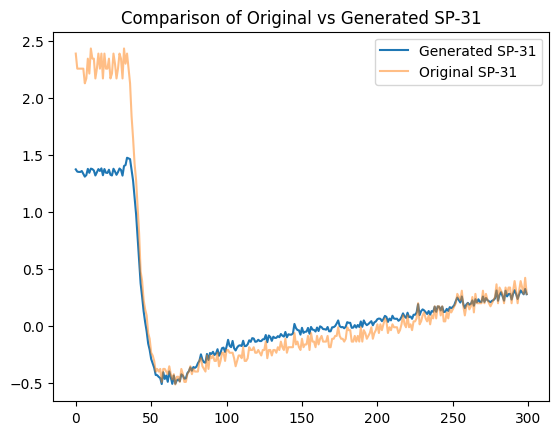

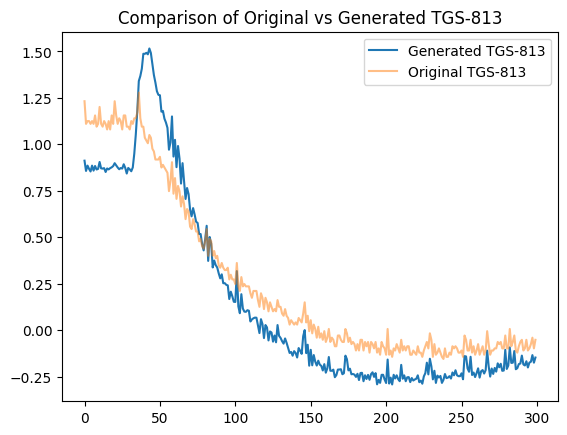

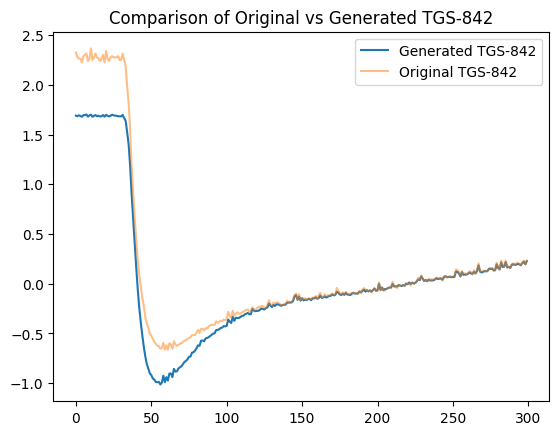

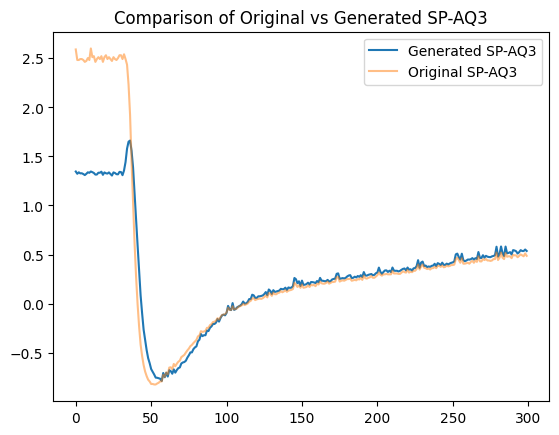

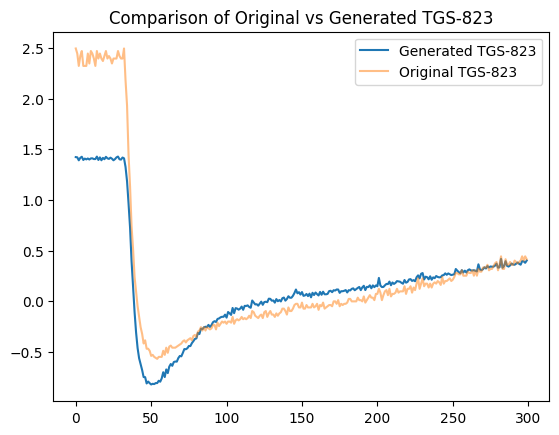

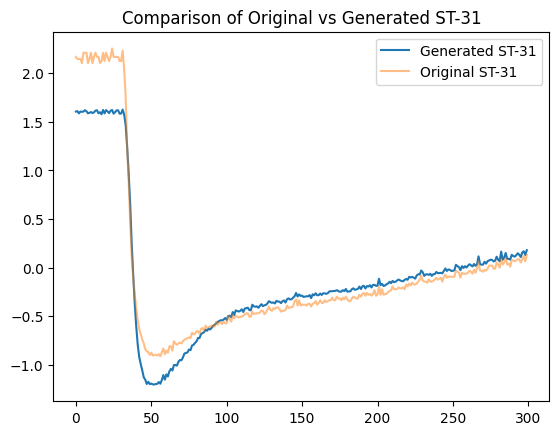

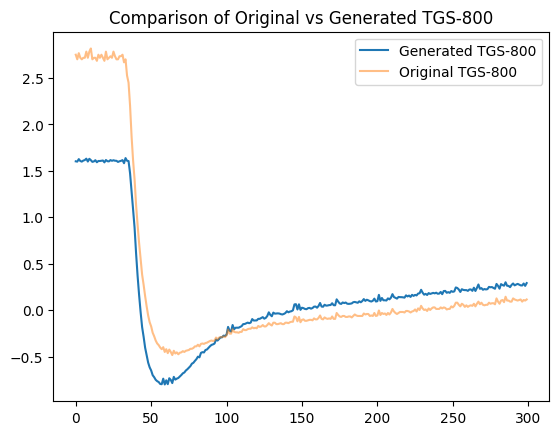

In [ ]:
model.eval()
with torch.no_grad():
    sample_idx = 0  # Choose any real input
    x_real = X_tensor[sample_idx].unsqueeze(1)  # shape: (300, 1, 8)
    generated = model(x_real).squeeze(1).numpy()  # shape: (300, 8)

# Plot example
import matplotlib.pyplot as plt
SENSOR_COLUMNS = ["SP-12A", "SP-31", "TGS-813", "TGS-842", "SP-AQ3", "TGS-823", "ST-31", "TGS-800"]
for i in range(8):
    plt.plot(generated[:, i], label=f'Generated {SENSOR_COLUMNS[i]}')
    plt.plot(X_tensor[sample_idx, :, i].numpy(), label=f'Original {SENSOR_COLUMNS[i]}', alpha=0.5)
    plt.legend()
    plt.title(f"Comparison of Original vs Generated {SENSOR_COLUMNS[i]}")
    plt.show()


# plt.plot(generated[:, 7], label='Generated Sensor 1')
# plt.plot(X_tensor[sample_idx, :, 7].numpy(), label='Original Sensor 1', alpha=0.5)
# plt.legend()
# plt.title("Comparison of Original vs Generated Sensor Signal")
# plt.show()


In [ ]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=8, d_model=64, nhead=4, num_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output_proj(x)

# Initialize model
model = TimeSeriesTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Hyperparameters for Early Stopping
best_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 10
patience_counter = 0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for x_batch, _ in train_loader:
        output = model(x_batch)
        loss = criterion(output, x_batch)

        if torch.isnan(loss):
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, _ in val_loader:
            val_output = model(x_val)
            val_loss = criterion(val_output, x_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss - 1e-5:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        print(f"⚠️ No val improvement ({patience_counter}/{patience})")

    if patience_counter >= patience:
        print("⏹️ Early stopping triggered!")
        break



Epoch 1 | Train Loss: 1.019842 | Val Loss: 0.713108
Epoch 2 | Train Loss: 0.757698 | Val Loss: 0.513575
Epoch 3 | Train Loss: 0.560000 | Val Loss: 0.380555
Epoch 4 | Train Loss: 0.405409 | Val Loss: 0.296365
Epoch 5 | Train Loss: 0.325932 | Val Loss: 0.249949
Epoch 6 | Train Loss: 0.276488 | Val Loss: 0.226520
Epoch 7 | Train Loss: 0.260839 | Val Loss: 0.212948
Epoch 8 | Train Loss: 0.230399 | Val Loss: 0.202401
Epoch 9 | Train Loss: 0.217673 | Val Loss: 0.190512
Epoch 10 | Train Loss: 0.209692 | Val Loss: 0.176568
Epoch 11 | Train Loss: 0.187310 | Val Loss: 0.161754
Epoch 12 | Train Loss: 0.183827 | Val Loss: 0.147913
Epoch 13 | Train Loss: 0.167278 | Val Loss: 0.136789
Epoch 14 | Train Loss: 0.166464 | Val Loss: 0.127962
Epoch 15 | Train Loss: 0.151455 | Val Loss: 0.120675
Epoch 16 | Train Loss: 0.157087 | Val Loss: 0.114793
Epoch 17 | Train Loss: 0.134861 | Val Loss: 0.109946
Epoch 18 | Train Loss: 0.145037 | Val Loss: 0.105326
Epoch 19 | Train Loss: 0.125658 | Val Loss: 0.100768
Ep

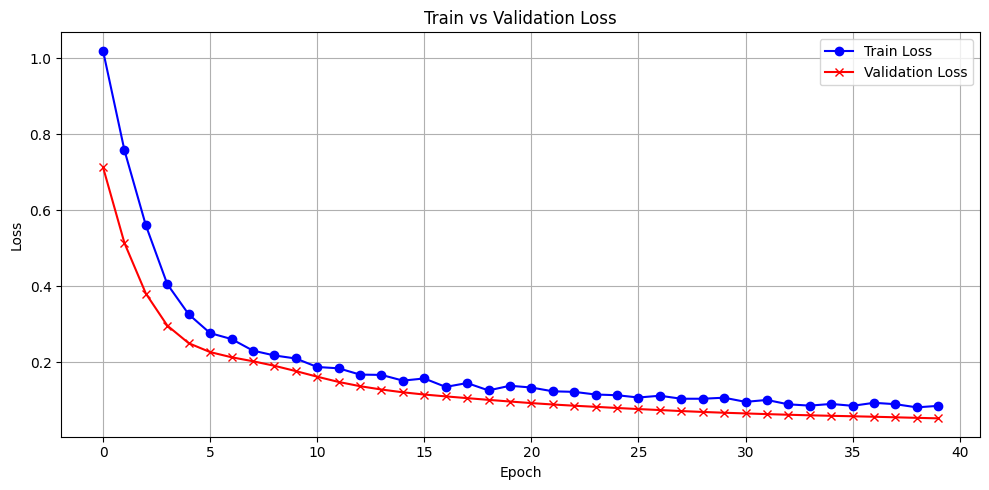

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color='blue', marker='o')
plt.plot(val_losses, label="Validation Loss", color='red', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Real Data

In [ ]:
import numpy as np

X_real = []
y_real = []

for x, label in normalized_data:
    X_real.append(x)
    y_real.append(label)

X_real = np.array(X_real)  # shape: (num_samples, 300, 8)
y_real = np.array(y_real)  # shape: (num_samples,)


In [ ]:
import torch
from torch.utils.data import TensorDataset

# Extract features and labels
X_real = []
y_real = []

for x, label in normalized_data:
    X_real.append(x)     # shape: (300, 8)
    y_real.append(label) # class: 0, 1, or 2

# Convert to tensors
X_real = torch.tensor(X_real, dtype=torch.float32)   # shape: (N, 300, 8)
y_real = torch.tensor(y_real, dtype=torch.long)      # shape: (N,)

# Create a TensorDataset
real_dataset = TensorDataset(X_real, y_real)


/tmp/ipython-input-11-549034425.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_real = torch.tensor(X_real, dtype=torch.float32)   # shape: (N, 300, 8)


#Generated Data

In [ ]:
X_gen = []
y_gen = []

for x_sample, label in real_dataset:
    x_tensor = torch.tensor(x_sample).unsqueeze(0).float()  # (1, 300, 8)
    with torch.no_grad():
        x_fake = model(x_tensor).squeeze(0).numpy()  # (300, 8)
    X_gen.append(x_fake)
    y_gen.append(label)

X_gen = np.array(X_gen)
y_gen = np.array(y_gen)



/tmp/ipython-input-13-4109264743.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x_sample).unsqueeze(0).float()  # (1, 300, 8)


#Combined Data

In [ ]:
X_combined = np.concatenate([X_real, X_gen], axis=0)
y_combined = np.concatenate([y_real, y_gen], axis=0)


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=2, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # (B, 300, 8)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split


def evaluate_classifier(X, y, name="Dataset"):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

    # Convert to tensors
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long()), batch_size=32)

    # Train classifier
    model = LSTMClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        for xb, yb in train_loader:
            out = model(xb)
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb).argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"{name} Accuracy: {acc:.4f}")

    # Plot CM
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HQ", "AQ", "LQ"], yticklabels=["HQ", "AQ", "LQ"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc


/tmp/ipython-input-18-3500996580.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()), batch_size=32, shuffle=True)
/tmp/ipython-input-18-3500996580.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long()), batch_size=32)


Real Data Accuracy: 0.7500


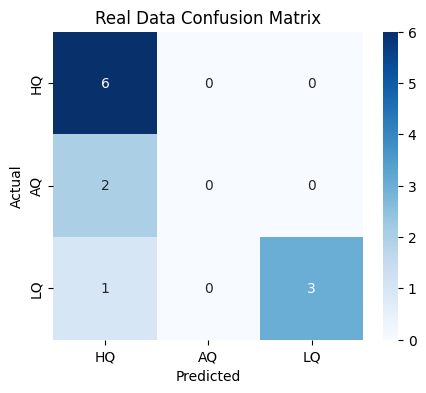

Generated Data Accuracy: 0.6667


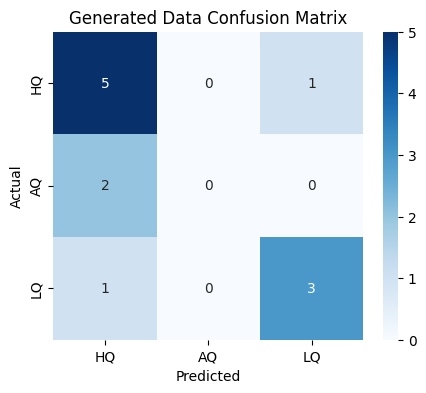

Real + Generated Accuracy: 0.7500


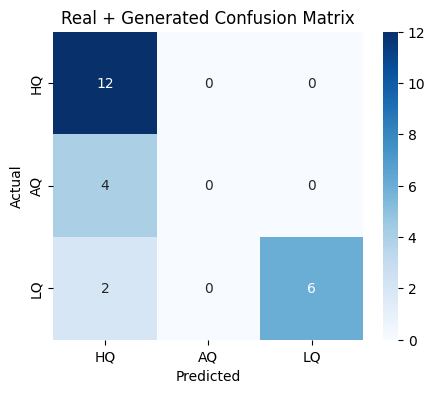

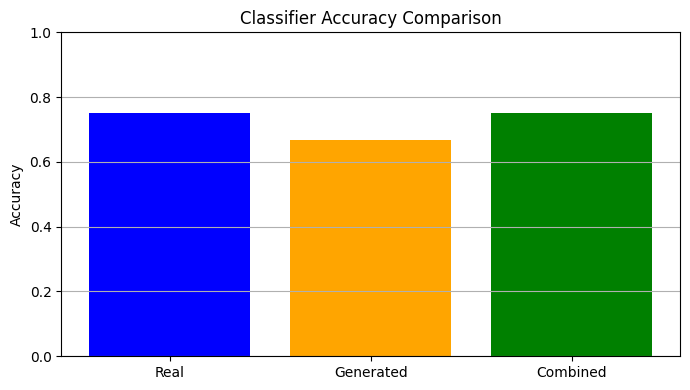

In [ ]:
acc_real = evaluate_classifier(X_real, y_real, name="Real Data")
acc_gen = evaluate_classifier(X_gen, y_gen, name="Generated Data")
acc_comb = evaluate_classifier(X_combined, y_combined, name="Real + Generated")

plt.figure(figsize=(7, 4))
plt.bar(["Real", "Generated", "Combined"], [acc_real, acc_gen, acc_comb], color=["blue", "orange", "green"])
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
